# 0. import

In [ ]:
# basic torch modules, classes and functions
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

# image datasets and pre-processing
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

# other utils libraries
import time
import numpy as np
import matplotlib.pyplot as plt

# for some math function such as sqrt
import math

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# 1. data set simulation

In [ ]:
class gen_sample_Tran(Dataset):
    def __init__(self, m, w,sigma):
      self.m = m
      self.x = torch.randn(m,w.size(dim=1) )
      self.y = torch.mm(self.x, torch.transpose(w, 0, 1) )+sigma * torch.randn(m,w.size(dim=0))

    def __len__(self):
        return self.m

# 2.1. convex model

In [ ]:
def gen_layer_1(w_0):
#hid_size is a vector of integers indicate dimension of each Linear
    mymodel = nn.Sequential(nn.Linear(w_0.size(dim =1), w_0.size(dim =0) ,bias = False))
    mymodel[0].weight = torch.nn.Parameter(w_0)
    return mymodel

# 2.2. DLN model

In [ ]:
class Net_DLN(nn.Module):
    def __init__(self, Layers):
        super(Net_DLN, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip (Layers, Layers[1:]):
          self.hidden.append(nn.Linear(input_size, output_size,bias = False))
        self.initialize_weights()

    def forward(self, activation):
        L=len(self.hidden)
        for (l, linear_transform) in zip(range(L),self.hidden):
          if l<L-1:
#            activation = torch.relu(linear_transform(activation))
            activation =  linear_transform(activation)
          else:
            activation = linear_transform(activation)
        return activation

    def initialize_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight)


class Net_DLN_orth(nn.Module):
    def __init__(self, Layers):
        super(Net_DLN_orth, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip (Layers, Layers[1:]):
          self.hidden.append(nn.Linear(input_size, output_size,bias = False))
        self.initialize_weights(Layers)

    def forward(self, activation):
        L=len(self.hidden)
        for (l, linear_transform) in zip(range(L),self.hidden):
          if l<L-1:
#            activation = torch.relu(linear_transform(activation))
            activation =  linear_transform(activation)
          else:
            activation = linear_transform(activation)
        return activation

    def initialize_weights(self, Layers):
        index0 = np.argmax(Layers)
        i = 1
        for m in self.modules():
          if isinstance( m, nn.Linear ):
            if i<=index0 :
              gain = math.sqrt(Layers[i])
            else :
              gain = math.sqrt(Layers[i-1])
            nn.init.orthogonal_( m.weight,  gain = gain )
            i = i + 1

# 3.1 loss function

In [ ]:
def l2_loss(y,y_pred ):
  return torch.sum(torch.square(y-y_pred)) /2.0

# 5. Full code and plot

In [ ]:
# generate minimizer w
w=torch.randn(10,128)

####### the size of hidden layer
nnn=128
hid_size=[nnn, nnn, nnn  ]

# the size of all layers and other constant
Layers = np.append(hid_size, w.size(dim=0))
N=len(Layers)
a_N= 1/math.sqrt(np.prod(Layers))
Layers = np.append(w.size(dim=1), Layers)
print(Layers)

####### number of sample
m=1000

# generate data set
mydata_tran = gen_sample_Tran(m=m, w = w , sigma= 1)
print(f"condition number of X: {torch.linalg.cond(mydata_tran.x)}")

# generate DLN
print(device)
#model_DLN = Net_DLN(Layers).to(device)
#model_DLN = Net_DLN(Layers)
model_DLN = Net_DLN_orth(Layers)

print(f"DLN: {model_DLN}")
# initialization for convex problem
w_0 = model_DLN(torch.eye( w.size(dim=1) ))*a_N
# generate convex model
model_convex = gen_layer_1( torch.transpose(w_0, 0, 1) )

print(f"convex model: {model_convex}")



# learning rate
eta_max = w.size(dim=0)/(N *torch.linalg.norm(mydata_tran.x,ord=2)*torch.linalg.norm(mydata_tran.x,ord=2))
print(f"eta_max: {eta_max}")

eta=eta_max/2
print(f"eta: {eta}")
eta_star=eta*N/w.size(dim =0)

optimizer_DLN = optim.SGD(model_DLN.parameters(), lr = eta )
optimizer_convex = optim.SGD(model_convex.parameters(), lr = eta_star )



[128 128 128 128  10]
condition number of X: 2.024534225463867
cpu
DLN: Net_DLN_orth(
  (hidden): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): Linear(in_features=128, out_features=128, bias=False)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=10, bias=False)
  )
)
convex model: Sequential(
  (0): Linear(in_features=128, out_features=10, bias=False)
)
eta_max: 0.0014032493345439434
eta: 0.0007016246672719717


In [ ]:
#for tensorboard plot
#from torch.utils.tensorboard import SummaryWriter
#%load_ext tensorboard
#log_dir = 'logs1'
#writer = SummaryWriter(log_dir)
nepochs = 100
DLN_loss = np.zeros(nepochs)
Convex_loss = np.zeros(nepochs)

for epoch in range(nepochs):
  yhat_tran = model_DLN( mydata_tran.x )*a_N
  myloss = l2_loss(yhat_tran, mydata_tran.y)
  DLN_loss[epoch] = myloss
    # optimizatin
  optimizer_DLN.zero_grad() # zero out gradient
  myloss.backward() # back propagation
  optimizer_DLN.step() # updata parameters
#  print(myloss)
#  writer.add_scalar('DLN', myloss, epoch)


for epoch in range(nepochs):
#for epoch in range(nepochs):
  # build computation graph
  yhat_transp = model_convex( mydata_tran.x )
  myloss2=l2_loss(mydata_tran.y, yhat_transp  )
  Convex_loss[epoch] = myloss2
    # optimizatin
  optimizer_convex.zero_grad() # zero out gradient
  myloss2.backward() # back propagation
  optimizer_convex.step() # updata parameters
#  print(myloss2)
#  writer.add_scalar('Convex', myloss2, epoch)

#writer.flush()
#writer.close()

#%tensorboard --logdir=logs1

# 6. plot

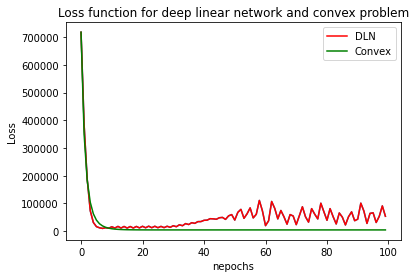

In [ ]:
import matplotlib.pyplot as plt
plt.plot(DLN_loss)

plt.plot(DLN_loss, color='r', label='DLN')
plt.plot(Convex_loss, color='g', label='Convex')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("nepochs")
plt.ylabel("Loss")
#plt.title(f'Loss function for network {Layers} and convex problem')
plt.title(f'Loss function for deep linear network and convex problem')


# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()
